# Model reduction 

**goal:** finding the minimum adequate model (i.e. the most parsimonious one)  

**steps:**
1. Importing the data & checking for missing values
2. Inspecting the distributions
3. Checking for redundancies among predictors 
- with correlations
- with the variance inflation factor
--> throwing out redundant variables
4. Preprocessing the data: scale the predictors
5. Reduction using p-values
- build a full model (glm)
- do backwards reduction by throwing out the non-significant variable with the highest p-value (until all variables are significant)
- compare minimum adequate model with null model
6. Reduction using AIC
- build candidate models (glms)
- compare candidate models with each other and with null model using AIC 
- the one with lowest AIC is the minimum adequate model (if it is at least 2 points lower in AIC)
7. Split the dataset in different ways (10:90, 30:70, 50:50)
- calculate the AUC
- compare the outcome / AUC for different splitting ratios

## Installing the data set

In [1]:
#pip install ucimlrepo

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import math
import numpy as np
import scipy.stats as stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.multitest import multipletests
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.linear_model import _glm
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [3]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
seoul_bike_sharing_demand = fetch_ucirepo(id=560) 
  
# data (as pandas dataframes) 
X = seoul_bike_sharing_demand.data.features 
y = seoul_bike_sharing_demand.data.targets 
  
# metadata 
print(seoul_bike_sharing_demand.metadata) 
  
# variable information 
print(seoul_bike_sharing_demand.variables) 

{'uci_id': 560, 'name': 'Seoul Bike Sharing Demand', 'repository_url': 'https://archive.ics.uci.edu/dataset/560/seoul+bike+sharing+demand', 'data_url': 'https://archive.ics.uci.edu/static/public/560/data.csv', 'abstract': 'The dataset contains count of public bicycles rented per hour in the Seoul Bike Sharing System, with corresponding weather data and holiday information', 'area': 'Business', 'tasks': ['Regression'], 'characteristics': ['Multivariate'], 'num_instances': 8760, 'num_features': 13, 'feature_types': ['Integer', 'Real'], 'demographics': [], 'target_col': ['Functioning Day'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2020, 'last_updated': 'Mon Feb 05 2024', 'dataset_doi': '10.24432/C5F62R', 'creators': [], 'intro_paper': None, 'additional_info': {'summary': 'Currently Rental bikes are introduced in many urban cities for the enhancement of mobility comfort. It is important to make the rental bike available and a

In [4]:
# merge X and y into one df

df = pd.concat([X, y], axis = 1)
# print(df.isnull().sum()) # really no missing values
df.head()
# df.info() # get info about data type

,Date,Rented Bike Count,Hour,Temperature,Humidity,Wind speed,Visibility,Dew point temperature,Solar Radiation,Rainfall,Snowfall,Seasons,Holiday,Functioning Day
0,1/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,1/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,1/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,1/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,1/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes


In [5]:
df_num = df.select_dtypes(include = ['float64', 'int64'])
df_selected = df[['Rented Bike Count', 'Temperature', 'Humidity', 'Wind speed', 'Visibility', 'Dew point temperature', 'Solar Radiation', 'Rainfall', 'Snowfall']]

In [6]:
df_num.isna().sum()

Rented Bike Count        0
Hour                     0
Temperature              0
Humidity                 0
Wind speed               0
Visibility               0
Dew point temperature    0
Solar Radiation          0
Rainfall                 0
Snowfall                 0
dtype: int64

## Checking distributions

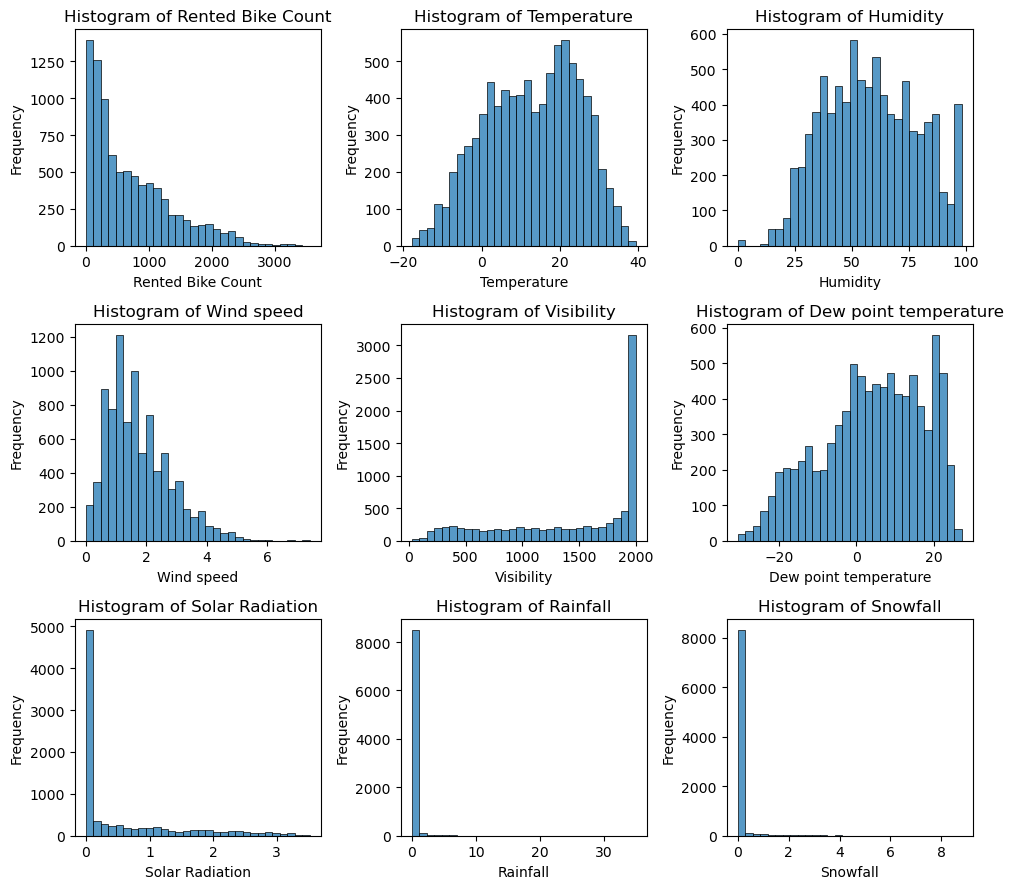

In [7]:
# initiating grid for histograms
h_cols = 3 # number of columns for histograms
h_rows = math.ceil(len(df_selected.columns) / h_cols) # dynamic calculation of rows

# Create a grid of subplots
fig, axes = plt.subplots(h_rows, h_cols, figsize = (10, 3 * h_rows))

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Iterate through numeric columns and create histograms
for i, col in enumerate(df_selected.columns):
    sns.histplot(data = df_selected, x = col, kde = False, bins = 30, ax = axes[i])  # Plot on specific subplot
    axes[i].set_title(f"Histogram of {col}")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Frequency")

# Turn off empty subplots if the number of plots is less than n_rows * n_cols
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

## Overview of correlations in the Soulbikes dataset

ValueError: Multi-dimensional indexing (e.g. `obj[:, None]`) is no longer supported. Convert to a numpy array before indexing instead.

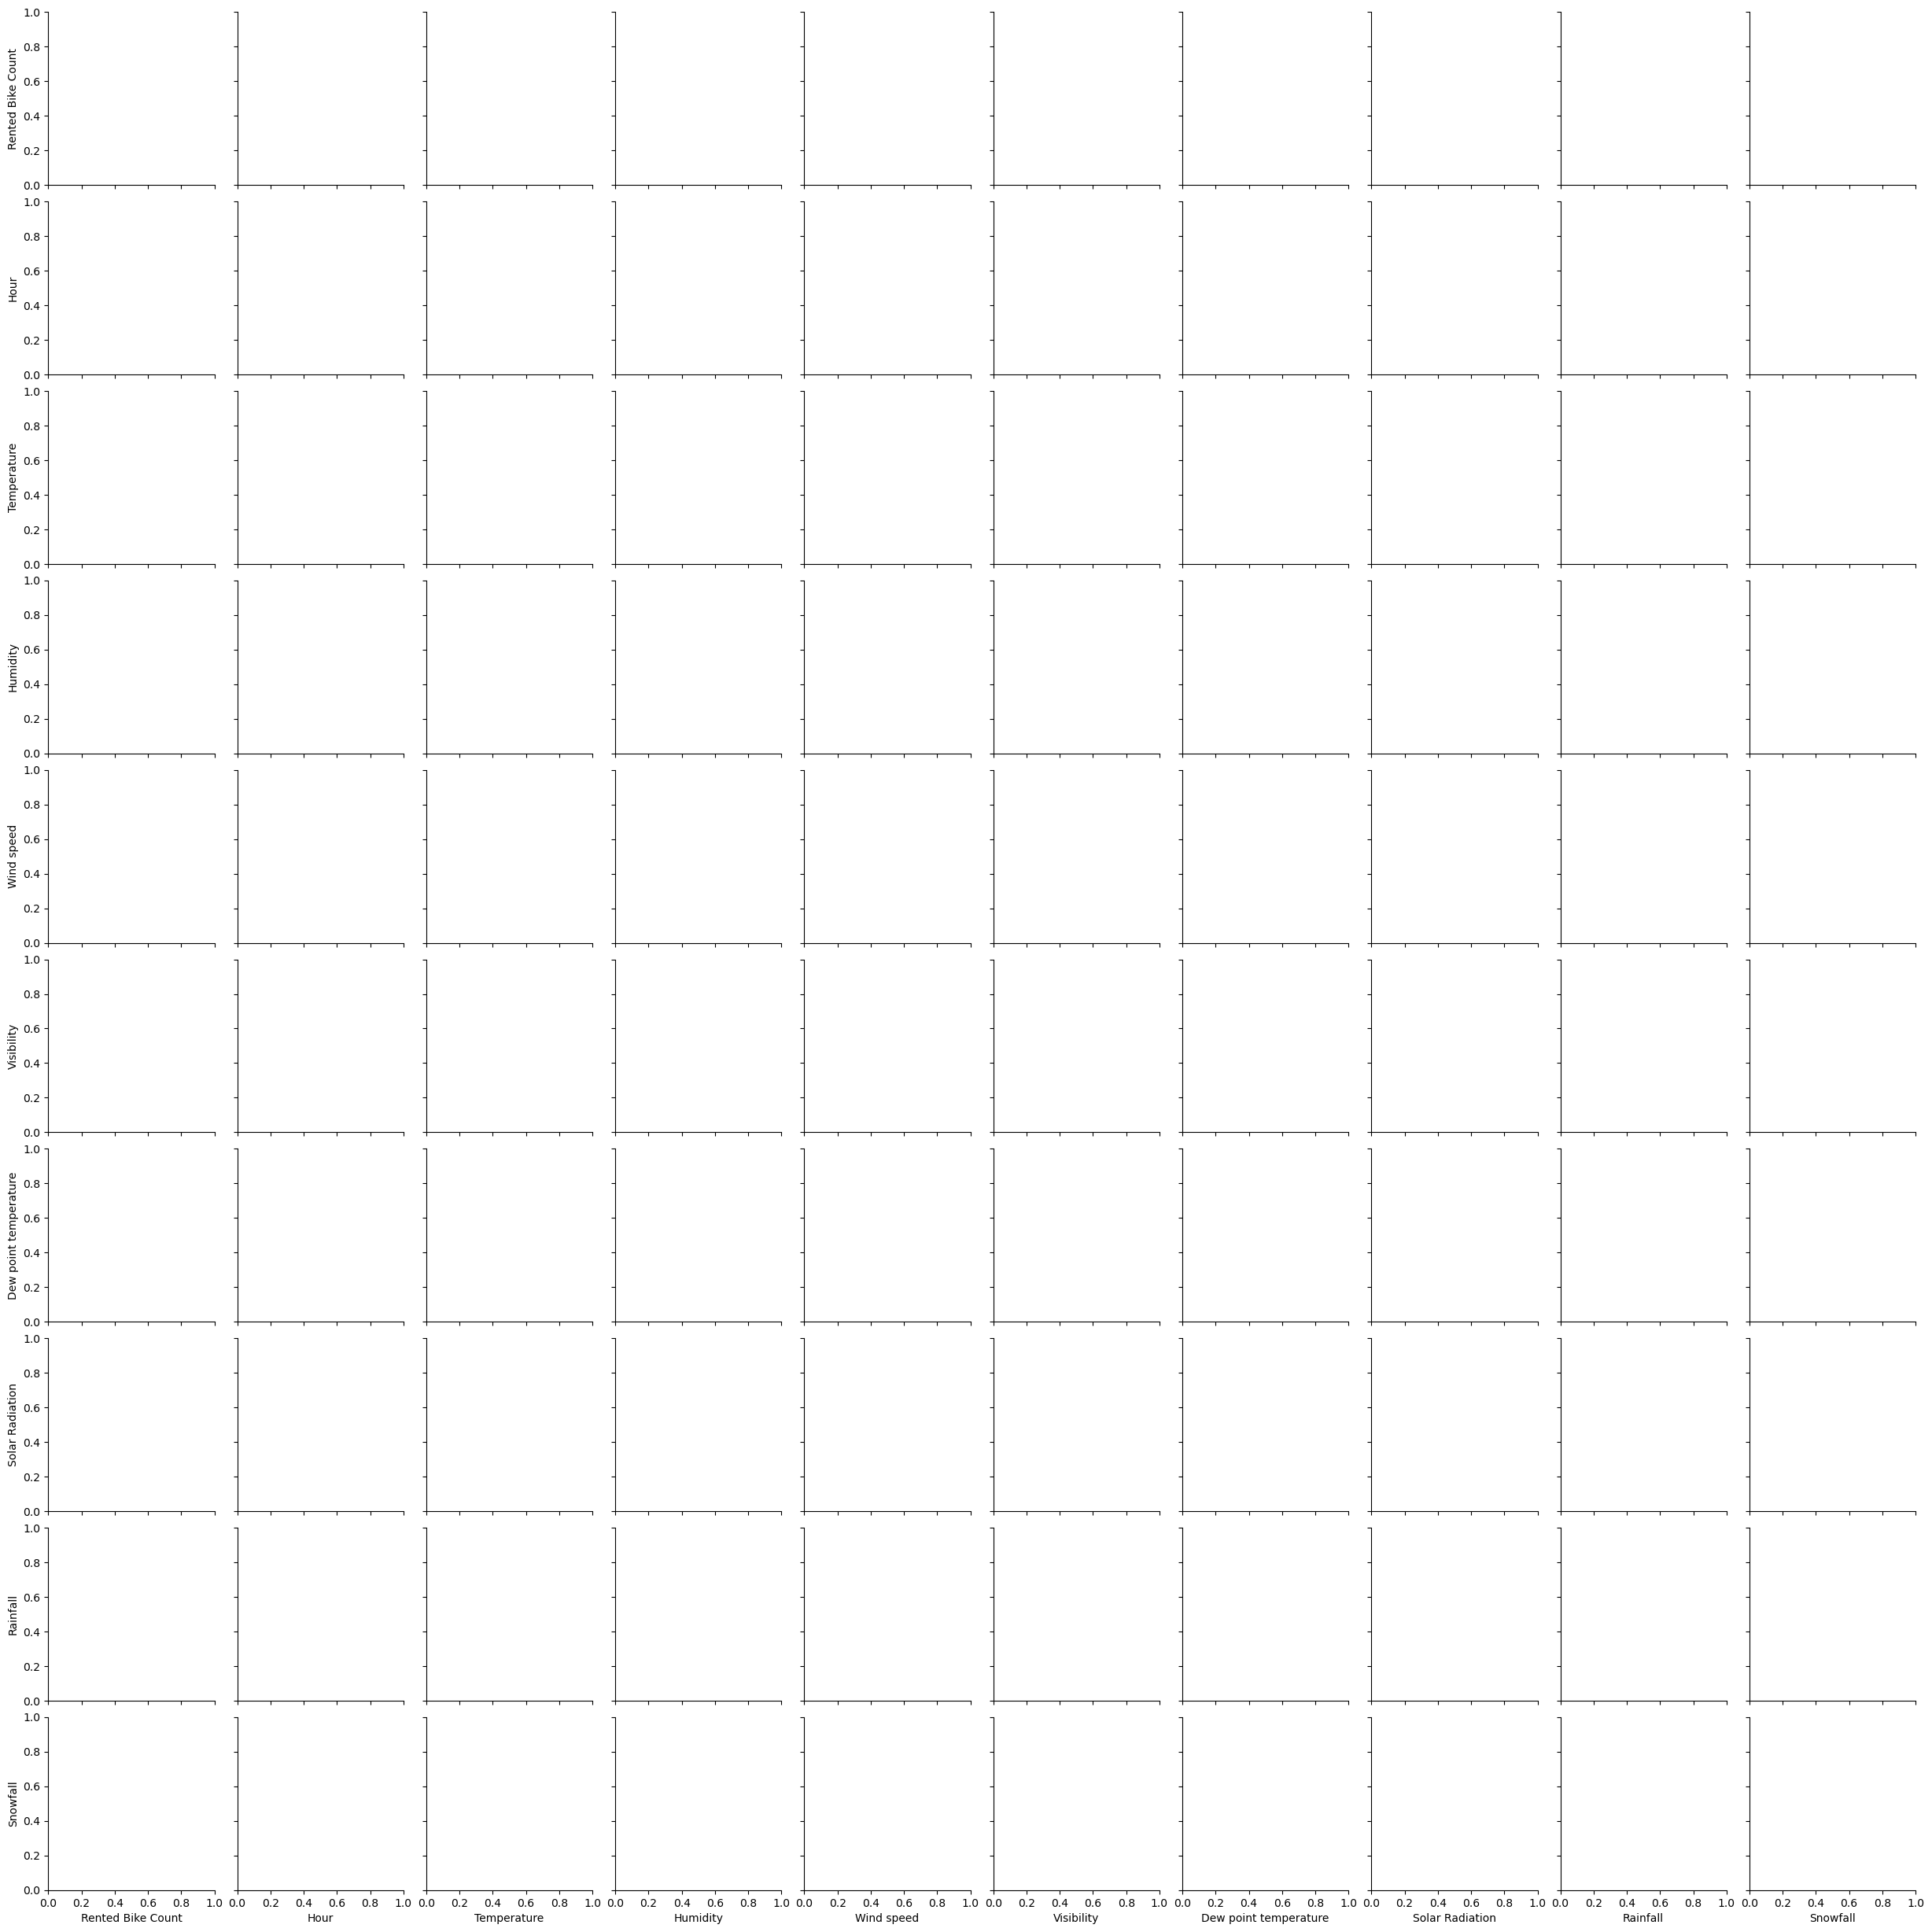

In [8]:
# Function to annotate correlation coefficients and p-values in the upper triangle
def corr_coefficient_with_pval(x, y, **kwargs):
    coef, p_value = stats.spearmanr(x, y, nan_policy='omit')  # Calculate correlation coefficient and p-value
    ax = plt.gca()  # Get the current axis
    cmap = plt.cm.coolwarm  # Use coolwarm colormap
    color = cmap((coef + 1) / 2)  # Normalize correlation to range [0, 1] for colormap
    ax.set_facecolor(color)  # Set the face color of the subplot

    # Determine significance level
    if p_value < 0.001:
        significance = "***"
    elif p_value < 0.01:
        significance = "**"
    elif p_value < 0.05:
        significance = "*"
    else:
        significance = ""

    # Annotate the coefficient and p-value with significance stars
    ax.annotate(f"{coef:.2f}{significance}", 
                xy=(0.5, 0.5), 
                xycoords=ax.transAxes, 
                ha="center", va="center", 
                fontsize=18, color="black")  # Adjust font size and color

# Create the pairplot
pairplot = sns.PairGrid(df_num, diag_sharey=False)

# Map plots for each section of the PairGrid
pairplot.map_diag(sns.kdeplot)  # KDE on the diagonal to smooth out
pairplot.map_lower(sns.scatterplot)  # Scatter plots in lower triangle
pairplot.map_upper(corr_coefficient_with_pval)  # Correlation coefficients and p-values in upper triangle

# Customize the axes labels
for ax in pairplot.axes.flat:
    ax.set_xlabel(ax.get_xlabel(), fontsize=18)
    ax.set_ylabel(ax.get_ylabel(), fontsize=18)

# Add title
pairplot.fig.suptitle("Pairplot with Spearman's Correlation Coefficients and Significance", 
                      y=1.01, fontsize=30)

plt.figtext(0.5, -0.02, "Significance levels: ***: p < 0.001, **: p < 0.01, *: p < 0.05", 
            ha="center", va="bottom", fontsize=18, color="black")


# Save the plot if needed
# pairplot.fig.savefig("Pairplot_with_significance_and_legend.png", dpi=300, bbox_inches='tight')

plt.show()

In [9]:
df.shape

(8760, 14)

Here, we tried to summarize the correlations in the dataset using scatterplots, heatmap, correlation coefficients and significance levels. The coefficients and significance levels are based on Spearman correlation tests because many of the variables were not normally distributed. 

Most of the variables correlate significantly, which is probably related to the high sample size (8760 observations). However, only some of the significant correlations have correlation coefficients that show that there is actually a correlation worth investigating. 

Especially interesting are correlations of rented bikes with the other variables:
- Rented bike count is significantly correlated with hour of the day, temperature, dew point temperature and solar radiation. As we would expect, people rent more bikes if it is warmer and sunnier.
- Rented bike count is significantly negatively correlated with humidity, rainfall and snowfall, as you would expect.

The high correlation between temperature and dew point temperature stands out. These variables are redundant. Some of the other variables are also related and might be better grouped together (e.g. humidity, rain and snow). 

A next step would be a multiple regression (on a reduced dataset without redundant variables) to investigate how weather variables influence bikes rented.

Some variables are rather normally distributed, but most are not.

## Checking for redundancies using correlations and VIF score

The correlation matrix above shows the following redundancies among predictors: 
- Temperature and dew point temperature
- Humidity is also highly correlated with a lot of other predictors

We checked the VIF for all predictors: 
- VIF > 5 for Temperature 
- VIF > 5 for Dew point temperature  
so we removed dew point temperature. 

Now the VIF is < 5 for all predictors.

In [20]:
# specify predictors and response
X = df_num.drop(columns=['Rented Bike Count', 'Dew point temperature'])
y = df_num['Rented Bike Count']

In [11]:
# Assume X is the DataFrame of explanatory variables
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

          Variable       VIF
0             Hour  3.921832
1      Temperature  3.228318
2         Humidity  4.868221
3       Wind speed  4.608625
4       Visibility  4.710170
5  Solar Radiation  2.246791
6         Rainfall  1.079158
7         Snowfall  1.120579


## Model reduction using p-values

## Model reduction using AIC

## Data splitting - comparison of AUC

Null model: bike count - 1
Full model: bike count - ['Hour', 'Temperature', 'Humidity', 'Wind speed', 'Visibility', 'Solar Radiation', 'Rainfall', 'Snowfall']
Candidate models: Temperature, Rainfall,
